# Calculations related to associating FRBs to host galaxies

In [100]:
# imports
import numpy as np
from importlib import reload
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy import stats
from astropy import wcs
from astropy import units
from astropy.table import Table

from frb import hosts

# For image viewing (comment out as desired)
from pypeit import ginga

## Pixel based (use SExtractor eventually)

### Load a DES r-band image

In [4]:
des_hdu = fits.open('example_5arcmin.fits')
des_hdu.info()

Filename: example_5arcmin.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU     108   (1140, 1140)   float32   
  1  MSK           1 ImageHDU        74   (1140, 1140)   int32   
  2  WGT           1 ImageHDU        72   (1140, 1140)   float32   


In [9]:
img = des_hdu[0].data
head0 = des_hdu[0].header
msk = des_hdu[1].data

### Simple eyeball

In [14]:
ginga.show_image(img)

(<ginga.util.grc.RemoteClient at 0x7f88133812e8>,
 <ginga.util.grc._channel_proxy at 0x7f883c51fd30>)

In [16]:
det_lvl = 20.  # DES counts

### Do it

In [18]:
gal_pix = (img > det_lvl) & (msk == 0)

In [19]:
Nall_pix = np.sum(msk==0)

In [20]:
frac = np.sum(gal_pix) / Nall_pix
frac

0.022715604852395557

### Assume 3%

In [29]:
P_1 = 0.03

In [30]:
P_3 = P_1**3
P_3

2.6999999999999996e-05

### Check

In [28]:
timg = img.copy()
timg[gal_pix] = -999
ginga.show_image(timg)

(<ginga.util.grc.RemoteClient at 0x7f8808ec27b8>,
 <ginga.util.grc._channel_proxy at 0x7f88093f4160>)

In [25]:
np.sum(gal_pix)

29247

In [26]:
ginga.show_image(msk)

(<ginga.util.grc.RemoteClient at 0x7f8808ee8d30>,
 <ginga.util.grc._channel_proxy at 0x7f8808ec2470>)

----

## Separation game

### WCS

In [32]:
des_wcs = wcs.WCS(head0)

In [33]:
des_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 326.105233583851  -40.9002293606808  
CRPIX : 570.0  570.0  
CD1_1 CD1_2  : -7.305555555556e-05  0.0  
CD2_1 CD2_2  : 0.0  7.305555555556e-05  
NAXIS : 1140  1140

In [39]:
(des_wcs.pixel_scale_matrix[0] * units.deg).to('arcsec')

<Quantity [-0.263,  0.   ] arcsec>

### Random catalog (for testing)

In [44]:
nsource = 13 * 4 * 25
nsource

1300

In [40]:
npix = 1140

In [45]:
rand_x = npix*np.random.rand(nsource)
rand_y = npix*np.random.rand(nsource)
rand_x

array([515.82658139,  59.33256371, 241.59355671, ..., 504.63690401,
       238.98632469, 298.95175749])

In [50]:
coord = des_wcs.pixel_to_world(rand_x, rand_y)

In [53]:
cat = Table()
cat['ra'] = coord.ra.value
cat['dec'] = coord.dec.value
cat['r' ] =21.

### Try me

In [99]:
reload(hosts)
d2d = hosts.random_separation(cat, des_wcs, 1140)

### A few plots

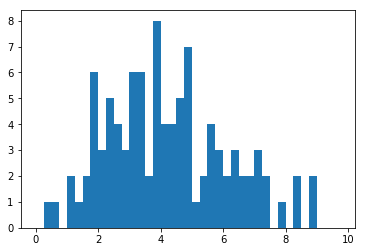

In [103]:
plt.clf()
ax=plt.gca()
ax.hist(d2d.to('arcsec').value, bins=np.arange(0.,10,0.25))
plt.show()

In [104]:
d2d_val = d2d.to('arcsec').value

In [107]:
xvals = np.arange(0., 10., 0.25)
yvals = np.zeros_like(xvals)
for kk,xval in enumerate(xvals):
    yvals[kk] = np.sum(d2d_val < xval)

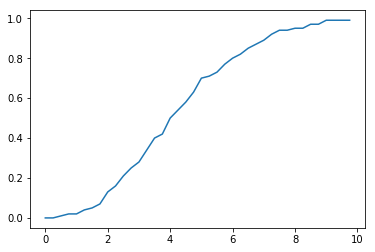

In [108]:
plt.clf()
ax = plt.gca()
ax.plot(xvals, yvals/d2d_val.size)
plt.show()

----

# Testing

In [70]:
des_wcs.pixel_to_world(des_wcs.wcs.crpix[0]-1, des_wcs.wcs.crpix[1]-1)

<SkyCoord (ICRS): (ra, dec) in deg
    (326.10523358, -40.90022936)>

In [93]:
des_wcs.wcs

       flag: 137
      naxis: 2
      crpix: 0x55599d238860
               570.00       570.00    
         pc: 0x55599d83d190
    pc[0][]:  -7.3056e-05   0.0000    
    pc[1][]:   0.0000       7.3056e-05
      cdelt: 0x55599d5e39a0
               1.0000       1.0000    
      crval: 0x55599d5e3f60
               326.11      -40.900    
      cunit: 0x55599e2f1470
             "deg"
             "deg"
      ctype: 0x55599e31c890
             "RA---TAN"
             "DEC--TAN"
    lonpole: 180.000000
    latpole: -40.900229
    restfrq: 0.000000
    restwav: 0.000000
        npv: 0
     npvmax: 0
         pv: 0x0
        nps: 0
     npsmax: 0
         ps: 0x0
         cd: 0x55599d18fb90
    cd[0][]:  -7.3056e-05   0.0000    
    cd[1][]:   0.0000       7.3056e-05
      crota: 0x55599d5e0ae0
               0.0000       0.0000    
     altlin: 2
     velref: 0
        alt: ' '
     colnum: 0
      colax: 0x55599d329540
                 0      0
    wcsname: UNDEFINED
      cname: 0x55599e

In [75]:
bottom_corner = des_wcs.pixel_to_world(0,0)
bottom_corner

<SkyCoord (ICRS): (ra, dec) in deg
    (326.16026394, -40.94178488)>

In [76]:
offset1 = bottom_corner.directional_offset_by(-45.*units.deg, np.sqrt(2)*units.arcmin)
offset1

<SkyCoord (ICRS): (ra, dec) in deg
    (326.13820543, -40.92511611)>

In [90]:
[float(i) for i in des_wcs.world_to_pixel(offset1)]

[227.99346843748145, 228.28051901134387]